In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from pprint import pprint
from argparse import ArgumentParser
import itertools
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline
# ## Initialize Model
from rnn_lib import utils
from rnn_lib.base_rnn import RNNCell
from rnn_lib.model import Model
from rnn_lib.dense_layers import DenseLayer
from rnn_lib.init_policies import W_TorchInit, U_TorchInit

#### song
from rnn_lib.dense_layers import ColumnEiDense
from rnn_lib.song_rnn import ColumnEiCell
from rnn_lib.init_policies import ColumnEi_FirstCell_U_InitPolicy, ColumnEiCell_W_InitPolicy
from rnn_lib.update_policies import ColumnEiSGD_Clip, ColumnEiDenseSGD

#### danns
from rnn_lib.dense_layers import EiDense
from rnn_lib.dann_rnn import EiRNNCell
from rnn_lib.init_policies import EiDenseWeightInit_WexMean, EiRNNCell_W_InitPolicy
from rnn_lib.update_policies import EiRNN_cSGD_UpdatePolicy2, DalesANN_cSGD_UpdatePolicy2

In [2]:
# ## Load Dataset
def plot_dataset(data, num_samples=5):
    """Plots a few samples from the dataset."""
    fig, axes = plt.subplots(num_samples, 1, figsize=(8, num_samples * 2))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        sample_idx = np.random.randint(0, data['inputs_series'].shape[0])
        inputs = data['inputs_series'][sample_idx]
        targets = data['targets_series'][sample_idx]
        coherence = data['coherence_series'][sample_idx]
        masks = data['mask_series'][sample_idx]

        axes[i].plot(inputs[:,0], label=r"$I_1$")
        axes[i].plot(inputs[:,1], label=r"$I_2$")
        axes[i].plot(targets[:,0], label=r"$r_{1}$")
        axes[i].plot(targets[:,1], label=r"$r_{2}$")
        axes[i].plot(masks, label="mask")
        axes[i].axhline(coherence, label="coherence")
        axes[i].set_title(f"Sample {i+1} ")
        axes[i].legend()

    plt.xlabel("timesteps")
    plt.show()

# Load Dataset
PLAYGROUND_DIR = "~/logs/EI_RLDM/decision_making"
dataset_path = f"{PLAYGROUND_DIR}/datasets/decision_making_data.npz"
data = np.load(dataset_path)
inputs_series = data['inputs_series']
targets_series = data['targets_series']
coherence_series = data['coherence_series']
mask_series = data['mask_series']

In [3]:
# Call the function to visualize dataset
# plot_dataset(data, num_samples=1)

In [4]:
# ## Set Hyperparameters
input_features = 2
n_output_classes = 2
n_hidden = 125
device = 'cpu'
test_interval = 1
model_type = 'colei' 

l1_lambda = 0.
l2_lambda = 0.

n_seeds = 1
seeds = [i for i in range(n_seeds)]
grad_clip_list = [1]
rad_list = [1.2]
lr_list = [6e-4]
decay = 0.99
optimi_list = ["adam"]
lr_list = [round(learning_rate, 4) for learning_rate in lr_list]
ei_ratio_list = [4]
para_comb = list(itertools.product(seeds, lr_list, grad_clip_list, rad_list, ei_ratio_list, optimi_list)) # 
(seed, learning_rate, grad_clip, rad, ei_ratio, optimi) = para_comb[0]


In [5]:
batch_size = 200
test_size = 100
valid_size = 100
num_batches = 1 #len(data_train) // batch_size
n_epochs = 600#len(data_train) // batch_size # Adjust epochs based on batch size
decision_threshold = 0.25
stimulus_onset = 10 
stimulus_duration = 21

In [6]:
# ## Split Dataset
data_train = inputs_series[:-valid_size-test_size]
targets_train = targets_series[:-valid_size-test_size]
masks_train = mask_series[:-valid_size-test_size]
coherence_train = coherence_series[:-valid_size-test_size]

data_valid = inputs_series[-valid_size-test_size:-test_size]
masks_valid = mask_series[-valid_size-test_size:-test_size]
targets_valid = targets_series[-valid_size-test_size:-test_size]
coherence_valid = coherence_series[-valid_size-test_size:-test_size]
data_valid = torch.from_numpy(data_valid).float().to(device)
targets_valid = torch.from_numpy(targets_valid).float().to(device)

data_test = inputs_series[-test_size:]
masks_test = mask_series[-test_size:]
targets_test = targets_series[-test_size:]
coherence_test = coherence_series[-test_size:]
data_test = torch.from_numpy(data_test).float().to(device)
targets_test = torch.from_numpy(targets_test).float().to(device)

In [ ]:
# ## Initialize Model
# Set model type ('rnn' for vanilla RNN, 'colei' for Song et al. model)
if model_type == "rnn":
    cells = [RNNCell(input_features, n_hidden, nonlinearity=F.relu, i2h_init_policy=U_TorchInit(), h2h_init_policy=W_TorchInit()),
             DenseLayer(n_hidden, n_output_classes, nonlinearity=None)]
elif model_type == "colei":
    pixel_mean = (data_train * masks_train[..., np.newaxis]).mean()
    cells = [ColumnEiCell(input_features, (n_hidden, ei_ratio),
                          nonlinearity=F.relu, 
                          i2h_init_policy=ColumnEi_FirstCell_U_InitPolicy(pixel_mean=pixel_mean), 
                          h2h_init_policy=ColumnEiCell_W_InitPolicy(radius=rad), 
                          update_policy=ColumnEiSGD_Clip(max=grad_clip)),
             ColumnEiDense(n_hidden, (n_output_classes, ei_ratio),
                           nonlinearity=None, update_policy=ColumnEiDenseSGD(max=grad_clip))
            ]
elif model_type == "danns":
    cells = [EiRNNCell(input_features, n_hidden, max(n_hidden//(ei_ratio+1), 1), max(n_hidden//(ei_ratio+1), 1),
                       nonlinearity=F.relu,
                       h2h_init_policy=EiRNNCell_W_InitPolicy(numerator=1/3, random=False)),
            EiDense(n_hidden, n_output_classes, max(n_output_classes//(ei_ratio+1),1),
                     nonlinearity=None, 
                     weight_init_policy=EiDenseWeightInit_WexMean(numerator=2))
            ]
    for cell in cells[-1:]:
        cell.update_policy = DalesANN_cSGD_UpdatePolicy2(max_grad_norm=grad_clip)
    for cell in cells[:-1]:
        cell.update_policy = EiRNN_cSGD_UpdatePolicy2(max_grad_norm=grad_clip)
else:
    raise ValueError("Invalid model type")

model = Model(cells)
model.init_weights()
model.reset_hidden(batch_size=batch_size)

if optimi == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.zero_grad()
# else:
    # model.zero_grad()
    
model.to(device)

In [ ]:
params = utils.Params()
# Set model type ('rnn' for vanilla RNN, 'colei' for Song et al. model)
params.model_type = model_type
params.grad_clip = grad_clip
params.ei_ratio = ei_ratio
params.rad = rad
params.seed = seed
params.batch_size = batch_size
params.n_epochs = n_epochs
params.lr  = learning_rate
params.n_hidden = n_hidden
params.results_dir = f"{PLAYGROUND_DIR}/saved_results"

utils.set_seed_all(params.seed)
params.write_to_config_yaml()

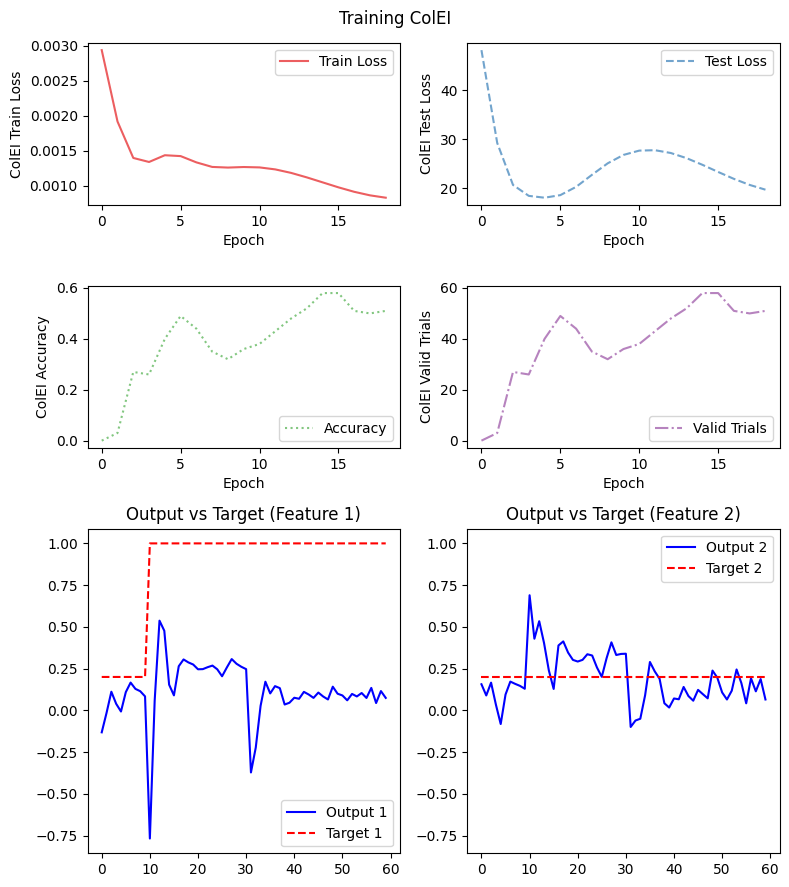

Epoch 20/600 | Learning Rate 0.0006 | Train Loss: 0.0008 | Test Loss: 18.9836 | Accuracy: 53.00% (Valid Trials: 53)


: 

In [12]:
# ## Training Loop

train_losses_plot, test_losses_plot, accuracy_plot, valid_trials_plot = [], [], [], []
update_i = 0   # update counter
results = {k: [] for k in ["test_loss", "train_loss", "update", 
                           "outputs_test", "targets_test", 
                           "accuracy", "valid_trial_count"]}

# Initialize Plot
plt.ion()

indices = np.random.permutation(len(data_train))
for epoch in range(n_epochs):
    train_losses = []

    for i in range(num_batches):
        batch_idx = indices[i * batch_size: (i + 1) * batch_size]
        batch_data = torch.from_numpy(data_train[batch_idx]).float().to(device)
        batch_targets = torch.from_numpy(targets_train[batch_idx]).float().to(device)
        batch_masks = torch.from_numpy(masks_train[batch_idx]).float().to(device)
        batch_coherence = torch.from_numpy(coherence_train[batch_idx]).float().to(device)

        model.train()
        model.reset_hidden(batch_size=batch_size)
        if optimi == "sgd":
            model.zero_grad()
        else:
            optimizer.zero_grad()
        
        loss_total = 0

        for trial in range(batch_data.shape[1]):
            output = model(batch_data[:, trial, :])
            target = batch_targets[:, trial, :]
            mask = batch_masks[:, trial]

            loss = F.mse_loss(output, target, reduction='none')
            loss = loss * mask.unsqueeze(-1)
            # Compute L1 manually
            l1_loss = sum(torch.sum(torch.abs(p)) for p in model.parameters())

            # Final loss with L1 + L2 (L2 handled by optimizer)
            loss_total += loss.mean() + l1_lambda * l1_loss
        loss_total /= batch_masks.sum()

        # Backpropagation
        loss_total.backward()
        if optimi == "sgd":
            # nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            model.update(lr=learning_rate, max_grad_norm=grad_clip)
            model.zero_grad()
        else:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        train_losses.append(loss_total.item())
       
        update_i += 1 # update counter
    
    # if optimi == "sgd":
    #         learning_rate = learning_rate * decay
    if epoch % test_interval == 0:
        # ## Evaluate Test Accuracy

        model.eval()
        model.reset_hidden(batch_size=test_size)
        test_loss_total = 0
        outputs_test = []
        
        for trial in range(data_test.shape[1]):
            test_output = model(data_test[:, trial, :]).detach()  # Detach from computation graph
            test_target = targets_test[:, trial, :]
            test_loss = F.mse_loss(test_output, test_target)
            test_loss_total += test_loss.item()
            outputs_test.append(test_output.cpu().numpy())

        # Convert to numpy for plotting
        outputs_test = np.transpose(np.array(outputs_test), axes=[1, 0, 2])  # Shape: (batch, time, features)
        logits = outputs_test[:, stimulus_onset + stimulus_duration]  
        probs = np.exp(logits) / np.sum(np.exp(logits))

        # Compute test accuracy
        decisions = np.abs(outputs_test[:, :, 0] - outputs_test[:, :, 1]) > decision_threshold 
        prestimulus_valid = (decisions[:, :stimulus_onset].sum(axis=1) / stimulus_onset) < 0.25
        poststimulus_valid = (decisions[:, stimulus_onset:].sum(axis=1) / 
                                  (decisions.shape[1] - (stimulus_onset + stimulus_duration))) > 0.5
        valid_trials = prestimulus_valid & poststimulus_valid
        valid_indices = np.where(valid_trials)[0]
        
        if len(valid_indices) == 0:
            accuracy, valid_trial_count = 0.0, 0  # No valid trials
        else:
            timescale_of_interest = stimulus_onset + stimulus_duration
            correct_choices = (np.array(np.sign(outputs_test[valid_indices, timescale_of_interest, 0] 
                                                - outputs_test[valid_indices, timescale_of_interest, 1])) ==
                                np.array(np.sign(targets_test[valid_indices, timescale_of_interest, 0] 
                                                 - targets_test[valid_indices, timescale_of_interest, 1])))
            valid_trial_count = correct_choices.sum()
            accuracy = valid_trial_count / data_test.shape[0]
            
        train_loss_avg = np.mean(train_losses)


        # Print loss
        print((f"Epoch {epoch + 1}/{n_epochs} | " + 
              f"Learning Rate {learning_rate} | " + 
              f"Train Loss: {train_loss_avg:.4f} | " +
              f"Test Loss: {test_loss_total:.4f} | " +
              f"Accuracy: {accuracy * 100:.2f}% (Valid Trials: {valid_trial_count})"))


        # ## Update Loss Plots
        train_losses_plot.append(train_loss_avg)
        test_losses_plot.append(test_loss_total)
        accuracy_plot.append(accuracy)
        valid_trials_plot.append(valid_trial_count)
    
        results["update"].append(update_i)
        results["train_loss"].append(train_loss_avg)
        results["test_loss"].append(test_loss_total)
        results["outputs_test"].append(outputs_test)
        results["targets_test"].append(targets_test)
        results["accuracy"].append(accuracy)
        results["valid_trial_count"].append(valid_trial_count)
    
        clear_output(wait=True)
        fig, axes = plt.subplots(3, 2, figsize=(8, 9), gridspec_kw={'height_ratios': [1, 1, 2]})
        axes[2, 1].sharey(axes[2, 0])  # Share y-axis only in the third row

        labels = {"rnn": "RNN", 
          "colei": "ColEI", 
          "danns": "DANN"}
        fig.suptitle(f'Training {labels[model_type]}')
        COLORS = plt.get_cmap('Set1').colors
        linestyles = ['-', '--', ':', "-."]
        colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]

        # Train Loss Plot (Top Left)
        axes[0, 0].plot(train_losses_plot, color=colors[0], linestyle=linestyles[0],  alpha=0.7, label="Train Loss")
        axes[0, 0].set_ylabel(f"{labels[model_type]} Train Loss")
        axes[0, 0].set_xlabel("Epoch")
        axes[0, 0].legend()
        
        # Test Loss Plot (Top Right)
        axes[0, 1].plot(test_losses_plot, color=colors[1], linestyle=linestyles[1],  alpha=0.7, label="Test Loss")
        axes[0, 1].set_ylabel(f"{labels[model_type]} Test Loss")
        axes[0, 1].set_xlabel("Epoch")
        axes[0, 1].legend()

        # Accuracy Plot (Center Left)
        axes[1, 0].plot(accuracy_plot, color=colors[2], linestyle=linestyles[2], alpha=0.7, label="Accuracy")
        axes[1, 0].set_ylabel(f"{labels[model_type]} Accuracy")
        axes[1, 0].set_xlabel("Epoch")
        axes[1, 0].legend()

        # Valid Trials Plot (Center Right)
        axes[1, 1].plot(valid_trials_plot, color=colors[3], linestyle=linestyles[3], alpha=0.7, label="Valid Trials")
        axes[1, 1].set_ylabel(f"{labels[model_type]} Valid Trials")
        axes[1, 1].set_xlabel("Epoch")
        axes[1, 1].legend()
        
        # Model Output vs. Target (Feature 1) - Bottom Left
        sample_idx = np.random.randint(0, test_size)
        time_steps = np.arange(outputs_test.shape[1])
        axes[2, 0].plot(time_steps, outputs_test[sample_idx, :, 0], ls="-", label="Output 1", c="b")
        axes[2, 0].plot(time_steps, targets_test[sample_idx, :, 0].cpu().numpy(), ls="--", label="Target 1", c="r")
        axes[2, 0].set_title("Output vs Target (Feature 1)")
        axes[2, 0].legend()
        
        # Model Output vs. Target (Feature 2) - Bottom Right (Shares y-axis with Feature 1)
        axes[2, 1].plot(time_steps, outputs_test[sample_idx, :, 1], ls="-", label="Output 2", c="b")
        axes[2, 1].plot(time_steps, targets_test[sample_idx, :, 1].cpu().numpy(), ls="--", label="Target 2", c="r")
        axes[2, 1].set_title("Output vs Target (Feature 2)")
        axes[2, 1].legend()
        
        plt.tight_layout()
        plt.pause(0.1)


In [ ]:
# ## Save Model
params.get_exp_savepath().mkdir(parents=True, exist_ok=True)
if model_type == "colei":
    filestr = f"{params.get_exp_savepath()}/dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{learning_rate}_GC{grad_clip}_{optimi}" 
    model_save_path_root = f"{PLAYGROUND_DIR}/saved_models/batch_size-{batch_size}/seed-{seed}"
    model_save_path = f"{model_save_path_root}/dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{learning_rate}_GC{grad_clip}_{optimi}.pth"
else:
    filestr = f"{params.get_exp_savepath()}/dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{learning_rate}_GC{grad_clip}_{optimi}" 
    model_save_path_root = f"{PLAYGROUND_DIR}/saved_models/batch_size-{batch_size}/seed-{seed}"
    model_save_path = f"{model_save_path_root}/dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{learning_rate}_GC{grad_clip}_{optimi}.pth"
np.savez(filestr, **results)
print(f"Results saved at {filestr}.npz")
from pathlib import Path
model_save_path_root = Path(model_save_path_root)
model_save_path_root.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")
plt.ioff()
plt.show()